# Experiment description
## Hypothesis: 
Identified periodicity on agressive behavior phenomenon (experiment 1) is also observed considering other data subsets
## Method: 
Fourier analysis to identify periodicity on time series signals

Statistic mesaure to compare periodic values
## Time windows: 
- Year (by days) between 2017-2018
- Semester (by days) between 2017-2018
- Trimester (by days) between 2017-2018
- Month (by days) between 2017-2018
- #TODO with extended dataset: Years (by months) between 2017-2018

## Built-in methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import calendar
import scipy as sp
import scipy.fftpack
from scipy.signal import find_peaks

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [2]:
def fourier_analysis(signal):
    time = range(len(signal))
    fftdata = np.fft.fft(signal)
    fftdatafreq = np.zeros((len(signal)))

    for i in range(len(fftdata)):
        fftdatafreq[i] = abs(fftdata[i].real)

    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    
    unilateral_fft = fftdatafreq[0:len(fftdatafreq) // 2]
    plt.plot(time[1:len(fftdatafreq) // 2], unilateral_fft[1:])
    return unilateral_fft

In [3]:
def build_semester_list(year,semester=1):
    if semester == 1:
        month_list = ['01','02','03','04','05','06']
    if semester == 2:
        month_list = ['07','08','09','10','11','12']
    semester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(semester_list))

def build_trimester_list(year,trimester=1):
    if trimester == 1:
        month_list = ['01','02','03']
    if trimester == 2:
        month_list = ['04','05','06']
    if trimester == 3:
        month_list = ['07','08','09']
    if trimester == 4:
        month_list = ['10','11','12']
    trimester_list = map(lambda m: year+'/'+str(m), month_list)
    return (list(trimester_list))


In [4]:
def plot_fft_period_axis(signal_time_domain,unilateral_fft):
    fs = len(signal_time_domain)
    samples_fft = len(unilateral_fft)
    inv=unilateral_fft[1:][::-1]
    points_x = np.arange(samples_fft)
    period = fs/(samples_fft - points_x[1:])
    plt.axis([0, 20, 0, 55000])
    plt.plot(period,inv)

In [5]:
def get_frequency_peaks(unilateral_fft,distance):
    peaks, _ = find_peaks(unilateral_fft, distance=20)
    return peaks

In [6]:
def get_peaks_magnitude(unilateral_fft, peaks_location_array):
    peaks_magnitude = []
    for peak in peaks_location_array:
        magnitude = round(unilateral_fft[peak],2)
        peaks_magnitude.append(magnitude)
    return peaks_magnitude

In [7]:
def get_peaks_period(array_frequency_peaks,fs):
    peaks_period = []
    for peak in array_frequency_peaks:
        period = round((fs/peak),2)
        peaks_period.append(period)
    return peaks_period

In [38]:
def get_periods_by_peak(peaks,n_periods):
    period_values_array = {}
    for period in range(n_periods):
        period_values_array[period]=[]
        for peak in peaks:
            current_period = peaks[peak]['periods'][period]
            period_values_array[period].append(current_period)

    return period_values_array

In [47]:
def evaluate_periods_metrics(periods_by_peak):
    periods_metrics={}
    for period in periods_by_peak:
        periods_metrics[period]={}
        periods_metrics[period]['mean']=np.mean(periods_by_peak[period])
        periods_metrics[period]['std']=np.std(periods_by_peak[period])
    return periods_metrics

## Data

In [8]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

In [9]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date_period = pd.DataFrame(df_input.groupby(['ANIO','PERIODO_TS','date']).size(),columns=["total_eventos"])
df_by_date_period.reset_index(inplace=True)

# Results
## Year (by days) analysis

{'2017': {'frequency': [24, 52, 76, 104, 129, 151, 178], 'periods': [15.21, 7.02, 4.8, 3.51, 2.83, 2.42, 2.05], 'values': [1.72, 15.31, 1.5, 5.25, 0.68, 2.24, 0.59]}, '2018': {'frequency': [20, 42, 83, 104, 127, 157, 177], 'periods': [18.25, 8.69, 4.4, 3.51, 2.87, 2.32, 2.06], 'values': [1.84, 2.22, 1.56, 9.57, 1.25, 2.49, 0.46]}}


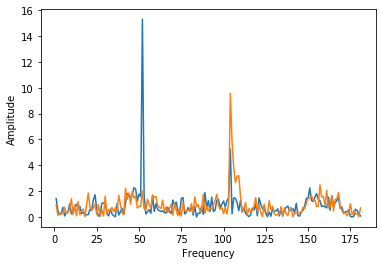

In [24]:
years=[['2017'],['2018']]
fft_events_in_subset = {}
time_events_normalized = {}
peaks = {}
for year in years:
    df_by_period=df_by_date_period[df_by_date_period.ANIO.isin(year)]
    events_on_period = pd.Series(df_by_period['total_eventos']).values
    time_events_normalized[year[0]] = events_on_period/events_on_period.max()
    fft_events_in_subset[year[0]] = fourier_analysis(time_events_normalized[year[0]])
    
    peaks[year[0]]={}
    peak_points = get_frequency_peaks(fft_events_in_subset[year[0]],20)
    peak_values = get_peaks_magnitude(fft_events_in_subset[year[0]],peak_points)
    peak_periods = get_peaks_period(list(peak_points),len(events_on_period))
    peaks[year[0]]['frequency']=list(peak_points)
    peaks[year[0]]['periods']=peak_periods
    peaks[year[0]]['values']=peak_values   
print(peaks)

In [48]:
#store peaks by period and evaluate mean and std
n_periods = 7
periods_by_peak = get_periods_by_peak(peaks,n_periods)
print(periods_by_peak)
print(evaluate_periods_metrics(periods_by_peak))

{0: [15.21, 18.25], 1: [7.02, 8.69], 2: [4.8, 4.4], 3: [3.51, 3.51], 4: [2.83, 2.87], 5: [2.42, 2.32], 6: [2.05, 2.06]}
{0: {'mean': 16.73, 'std': 1.5199999999999996}, 1: {'mean': 7.8549999999999995, 'std': 0.835}, 2: {'mean': 4.6, 'std': 0.19999999999999973}, 3: {'mean': 3.51, 'std': 0.0}, 4: {'mean': 2.85, 'std': 0.020000000000000018}, 5: {'mean': 2.37, 'std': 0.050000000000000044}, 6: {'mean': 2.0549999999999997, 'std': 0.0050000000000001155}}


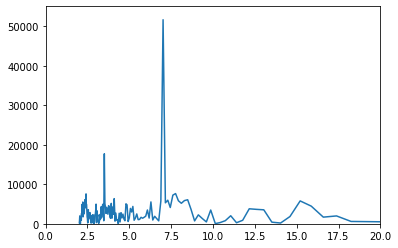

In [41]:
plot_fft_period_axis(events_on_period['2017'],fft_events_in_subset['2017'])

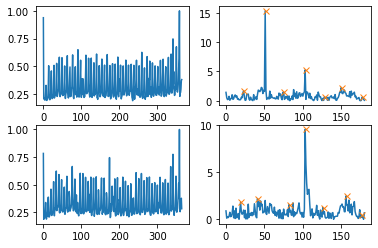

In [71]:
plt.figure(1)
plt.subplot(221)
plt.plot(time_events_normalized['2017'])

plt.subplot(222)
peaks, _ = find_peaks(fft_events_in_subset['2017'], distance=20)
plt.plot(fft_events_in_subset['2017'][1:])
plt.plot(peaks, fft_events_in_subset['2017'][peaks], "x")

plt.subplot(223)
plt.plot(time_events_normalized['2018'])

plt.subplot(224)
peaks, _ = find_peaks(fft_events_in_subset['2018'], distance=20)
plt.plot(fft_events_in_subset['2018'][1:])
plt.plot(peaks, fft_events_in_subset['2018'][peaks], "x")

plt.show()

## Semester (by days) analysis

{'2017-1': {'frequency': [6, 26, 52, 78], 'periods': [30.17, 6.96, 3.48, 2.32], 'values': [0.56, 11.6, 5.78, 2.24]}, '2017-2': {'frequency': [6, 26, 52, 79], 'periods': [30.67, 7.08, 3.54, 2.33], 'values': [0.19, 9.2, 4.05, 3.16]}, '2018-1': {'frequency': [5, 26, 52, 75], 'periods': [36.2, 6.96, 3.48, 2.41], 'values': [1.57, 8.93, 2.31, 1.83]}, '2018-2': {'frequency': [2, 26, 53, 79], 'periods': [92.0, 7.08, 3.47, 2.33], 'values': [1.21, 3.63, 3.76, 4.19]}}


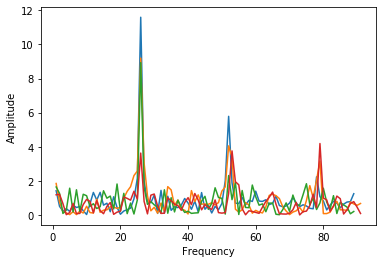

In [49]:
years=['2017','2018']
fft_events_in_subset = {}
time_events_normalized = {}
peaks = {}
for year in years:
    for i in range(1,3):
        period_list = build_semester_list(year,semester=i)
        df_by_period=df_by_date_period[df_by_date_period.PERIODO_TS.isin(period_list)]
        events_on_period = pd.Series(df_by_period['total_eventos']).values
        time_events_normalized[year+'-'+str(i)] = events_on_period/events_on_period.max()
        fft_events_in_subset[year+'-'+str(i)] = fourier_analysis(time_events_normalized[year+'-'+str(i)])
        
        peaks[year+'-'+str(i)]={}
        peak_points = get_frequency_peaks(fft_events_in_subset[year+'-'+str(i)],20)
        peak_values = get_peaks_magnitude(fft_events_in_subset[year+'-'+str(i)],peak_points)
        peak_periods = get_peaks_period(list(peak_points),len(events_on_period))
        peaks[year+'-'+str(i)]['frequency']=list(peak_points)
        peaks[year+'-'+str(i)]['periods']=peak_periods
        peaks[year+'-'+str(i)]['values']=peak_values
print(peaks)

In [50]:
#store peaks by period and evaluate mean and std
n_periods = 4
periods_by_peak = get_periods_by_peak(peaks,n_periods)
print(periods_by_peak)
print(evaluate_periods_metrics(periods_by_peak))

{0: [30.17, 30.67, 36.2, 92.0], 1: [6.96, 7.08, 6.96, 7.08], 2: [3.48, 3.54, 3.48, 3.47], 3: [2.32, 2.33, 2.41, 2.33]}
{0: {'mean': 47.260000000000005, 'std': 25.938809725968536}, 1: {'mean': 7.02, 'std': 0.06000000000000005}, 2: {'mean': 3.4925, 'std': 0.027726341266023524}, 3: {'mean': 2.3475, 'std': 0.03631459761583495}}


## Trimester (by days) analysis

['2017/01', '2017/02', '2017/03']
['2017/04', '2017/05', '2017/06']
['2017/07', '2017/08', '2017/09']
['2017/10', '2017/11', '2017/12']
['2018/01', '2018/02', '2018/03']
['2018/04', '2018/05', '2018/06']
['2018/07', '2018/08', '2018/09']
['2018/10', '2018/11', '2018/12']
{'2017-1': {'frequency': [13, 39], 'periods': [6.92, 2.31], 'values': [5.82, 1.3]}, '2017-2': {'frequency': [13, 39], 'periods': [7.0, 2.33], 'values': [7.57, 2.23]}, '2017-3': {'frequency': [13, 41], 'periods': [7.08, 2.24], 'values': [8.32, 1.08]}, '2017-4': {'frequency': [13, 38], 'periods': [7.08, 2.42], 'values': [3.99, 1.55]}, '2018-1': {'frequency': [13, 37], 'periods': [6.92, 2.43], 'values': [4.11, 1.22]}, '2018-2': {'frequency': [13, 39], 'periods': [7.0, 2.33], 'values': [6.86, 2.22]}, '2018-3': {'frequency': [13, 42], 'periods': [7.08, 2.19], 'values': [6.05, 0.58]}, '2018-4': {'frequency': [5, 27], 'periods': [18.4, 3.41], 'values': [1.08, 2.39]}}


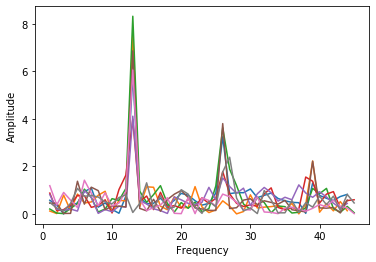

In [51]:
years=['2017','2018']
fft_events_in_subset = {}
time_events_normalized = {}
peaks = {}
for year in years:
    for i in range(1,5):
        period_list = build_trimester_list(year,trimester=i)
        print(period_list)
        df_by_period=df_by_date_period[df_by_date_period.PERIODO_TS.isin(period_list)]
        events_on_period = pd.Series(df_by_period['total_eventos']).values
        time_events_normalized[year+'-'+str(i)] = events_on_period/events_on_period.max()
        fft_events_in_subset[year+'-'+str(i)] = fourier_analysis(time_events_normalized[year+'-'+str(i)])
        
        peaks[year+'-'+str(i)]={}
        peak_points = get_frequency_peaks(fft_events_in_subset[year+'-'+str(i)],5)
        peak_values = get_peaks_magnitude(fft_events_in_subset[year+'-'+str(i)],peak_points)
        peak_periods = get_peaks_period(list(peak_points),len(events_on_period))
        peaks[year+'-'+str(i)]['frequency']=list(peak_points)
        peaks[year+'-'+str(i)]['periods']= peak_periods
        peaks[year+'-'+str(i)]['values']=peak_values
print(peaks)

In [52]:
#store peaks by period and evaluate mean and std
n_periods = 2
periods_by_peak = get_periods_by_peak(peaks,n_periods)
print(periods_by_peak)
print(evaluate_periods_metrics(periods_by_peak))

{0: [6.92, 7.0, 7.08, 7.08, 6.92, 7.0, 7.08, 18.4], 1: [2.31, 2.33, 2.24, 2.42, 2.43, 2.33, 2.19, 3.41]}
{0: {'mean': 8.434999999999999, 'std': 3.766931775331217}, 1: {'mean': 2.4575, 'std': 0.36785696948678304}}


## Month (by days) analysis

{'2017/01': {'frequency': [9], 'periods': [3.44], 'values': [1.66]}, '2017/02': {'frequency': [4], 'periods': [7.0], 'values': [2.98]}, '2017/03': {'frequency': [13], 'periods': [2.38], 'values': [1.02]}, '2017/04': {'frequency': [4], 'periods': [7.5], 'values': [2.4]}, '2017/05': {'frequency': [4], 'periods': [7.75], 'values': [1.98]}, '2017/06': {'frequency': [8], 'periods': [3.75], 'values': [1.45]}, '2017/07': {'frequency': [4], 'periods': [7.75], 'values': [1.56]}, '2017/08': {'frequency': [4], 'periods': [7.75], 'values': [2.17]}, '2017/09': {'frequency': [4], 'periods': [7.5], 'values': [2.04]}, '2017/10': {'frequency': [9], 'periods': [3.44], 'values': [1.94]}, '2017/11': {'frequency': [4], 'periods': [7.5], 'values': [1.86]}, '2017/12': {'frequency': [4], 'periods': [7.75], 'values': [2.33]}, '2018/01': {'frequency': [5], 'periods': [6.2], 'values': [1.42]}, '2018/02': {'frequency': [4], 'periods': [7.0], 'values': [1.62]}, '2018/03': {'frequency': [6], 'periods': [5.17], 'val

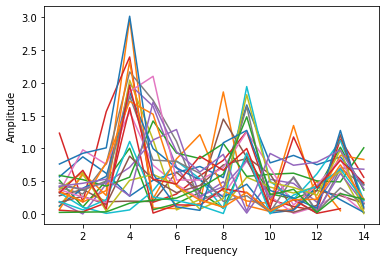

In [53]:
months = df_by_date_period.PERIODO_TS.unique()

fft_events_in_subset = {}
time_events_normalized = {}
peaks = {}
for month in months:
    period_list = []
    period_list.append(month)
    df_by_period=df_by_date_period[df_by_date_period.PERIODO_TS.isin(period_list)]
    events_on_period = pd.Series(df_by_period['total_eventos']).values
    time_events_normalized[month] = events_on_period/events_on_period.max()
    fft_events_in_subset[month] = fourier_analysis(time_events_normalized[month])

    peaks[month]={}
    peak_points = get_frequency_peaks(fft_events_in_subset[month],0.05)
    peak_values = get_peaks_magnitude(fft_events_in_subset[month],peak_points)
    peak_periods = get_peaks_period(list(peak_points),len(events_on_period))
    peaks[month]['frequency']=list(peak_points)
    peaks[month]['periods']=peak_periods
    peaks[month]['values']=peak_values
print(peaks)

In [54]:
#store peaks by period and evaluate mean and std
n_periods = 1
periods_by_peak = get_periods_by_peak(peaks,n_periods)
print(periods_by_peak)
print(evaluate_periods_metrics(periods_by_peak))

{0: [3.44, 7.0, 2.38, 7.5, 7.75, 3.75, 7.75, 7.75, 7.5, 3.44, 7.5, 7.75, 6.2, 7.0, 5.17, 2.31, 6.2, 7.5, 3.44, 7.75, 7.5, 7.75, 3.33, 7.75, 6.2]}
{0: {'mean': 6.064400000000001, 'std': 1.9387152034272594}}
